In [2]:
# import tensorflow as tf
# print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization, TimeDistributed, Bidirectional
# from tensorflow.keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tempfile

In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random


# Parameters
WINDOW_SIZE = 300
STEP_SIZE = 275
TOLERANCE = 0.1
MAX = 20000
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')
LABELS = []
X = []
y = []
well_represented = ['Fridge','Freezer','Washing Machine','Washer Dryer','Tumble Dryer','Dishwasher','Microwave','Toaster','Kettle',
                'Computer','Electric Heater','Hi-Fi','Overhead Fan']


In [65]:
# Function to extract overlapping windows from a signal
def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

# Function to process a single file and extract windows
def process_file(file_path, label_idx):
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)
    with open(file_path) as f:
        appliance_name = f.readline().strip().split(",")[1]

    if appliance_name not in df.columns:
        return []

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    return [(window, label_idx) for window in extract_windows(signal)]

# Function to load and balance the dataset
def load_balanced_dataset(data_dir, well_represented=well_represented):
    global LABELS, X, y

    label_map = {name: i for i, name in enumerate(well_represented)}
    all_windows = {label: [] for label in well_represented}

    # Step 1: Load all data first
    for class_dir in sorted(Path(data_dir).iterdir()):
        if not class_dir.is_dir():
            continue
        class_name = class_dir.name
        if class_name not in well_represented:
            continue
        label_idx = label_map[class_name]
        if class_name not in LABELS:
            LABELS.append(class_name)
        for file in class_dir.glob("*.csv"):
            windows = process_file(file, label_idx)
            all_windows[class_name].extend(windows)

    # Select reference class and determine target range
    ref_class = random.choice(well_represented)
    original_ref_count = len(all_windows[ref_class])
    ref_count = min(MAX, original_ref_count)
    print(f"Reference class: {ref_class} (using {ref_count} windows, originally had {original_ref_count})")

    min_required = int(ref_count * (1 - TOLERANCE))
    max_allowed = int(ref_count * (1 + TOLERANCE))
    cap = min(MAX, max_allowed)


    # Apply sampling per class
    for label in well_represented:
        class_windows = all_windows[label]

        needed = MAX

        if len(class_windows) >= needed:
            chosen = random.sample(class_windows, needed)
        else:
            repeat_count = (needed // len(class_windows)) + 1
            extended = class_windows * repeat_count
            chosen = extended[:needed]
            chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
                      for (w, lbl) in chosen]

        for window, label_idx in chosen:
            X.append(window)
            y.append(label_idx)

        print(f"{label}: {len(chosen)} samples")

    print("\nClass balance (target ±{:.1f}%, max cap = {}):".format(TOLERANCE * 100, MAX))
    for label in well_represented:
        print(f"{label}: {sum(np.array(y) == label_map[label])} windows")

    X_np = np.array(X)[..., np.newaxis]
    y_np = to_categorical(y, num_classes=len(LABELS))
    return X_np, y_np


X, y = load_balanced_dataset(DATA_DIR)

Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Pr

In [66]:

# Train-validation-test split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 12105 samples
Dishwasher          : 11943 samples
Electric Heater     : 12059 samples
Freezer             : 11983 samples
Fridge              : 12088 samples
Hi-Fi               : 11970 samples
Kettle              : 11951 samples
Microwave           : 12111 samples
Overhead Fan        : 11923 samples
Toaster             : 11999 samples
Tumble Dryer        : 11957 samples
Washer Dryer        : 11949 samples
Washing Machine     : 11962 samples

Class distribution in VALIDATION set:
Computer            : 5552 samples
Dishwasher          : 5672 samples
Electric Heater     : 5560 samples
Freezer             : 5646 samples
Fridge              : 5490 samples
Hi-Fi               : 5614 samples
Kettle              : 5627 samples
Microwave           : 5495 samples
Overhead Fan        : 5654 samples
Toaster             : 5613 samples
Tumble Dryer        : 5649 samples
Washer Dryer        : 5644 samples
Washing Machine     : 5584 samples

Cla

In [4]:
from keras.layers import Activation, Multiply, Add
from keras.utils import get_custom_objects
from keras.activations import relu
from keras.layers import Lambda


# Custom activation function: ReLU6 divided by 6
def relu6_div6(x):
    return relu(x, max_value=6) / 6

get_custom_objects().update({'relu6_div6': relu6_div6})

# Custom Gated-Linear-Unit Convolutionnal layers for the model
def Conv1DGLUBlock(filters, kernel_size):
    def block(x):
        linear = Conv1D(filters, kernel_size, padding='same')(x)
        gate = Conv1D(filters, kernel_size, padding='same')(x)
        gate_out = Activation(relu6_div6)(gate)
        # gate_out = Lambda(lambda x: relu(x, max_value=6) / 6)(gate)
        return Multiply()([linear, gate_out])
    return block

get_custom_objects().update({'Conv1DGLUBlock': Conv1DGLUBlock})

# Custom Residual Block with GLU
def ResidualBlock(filters, kernel_size):
    def block(x):
        out = Conv1DGLUBlock(filters, kernel_size)(x)
        out = Conv1D(filters, kernel_size=1, padding='same')(out)
        if x.shape[-1] != out.shape[-1]:
            x = Conv1D(filters, kernel_size=1, padding='same')(x)  # 1x1 conv to match channels
        return Add()([x, out])
    return block
get_custom_objects().update({'ResidualBlock': ResidualBlock})

In [119]:
from keras.models import Model
from keras.layers import Add

# Build the model using the custom GLU blocks
def build_glu_cnn_lstm_model(window_size, num_classes):
    input_layer = Input(shape=(window_size, 1))
    print(f"Input shape: {input_layer.shape}")


    x = ResidualBlock(filters=64, kernel_size=5)(input_layer)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    print(f"Input shape: {x.shape}")
    x = ResidualBlock(filters=128, kernel_size=3)(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Dropout(0.2)(x)

    # Optional LSTM
    x = LSTM(64)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting : NOT USED
early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [120]:
model = build_glu_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    verbose=1
)


Input shape: (None, 300, 1)
Input shape: (None, 150, 64)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_159 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_158 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 300, 64)   │          0 │ conv1d_159[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 300, 64)   │          0 │ conv1d_158[0][0], │
│ (Multiply)          │                   │            │ activation_73[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 300, 64)   │          0 │ conv1d_161[0][0], │
│                     │                   │            │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 150, 64)   │          0 │ add_44[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_163 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_162 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 150, 128)  │          0 │ conv1d_163[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_45         │ (None, 150, 128)  │          0 │ conv1d_162[0][0], │
│ (Multiply)          │                   │            │ activation_74[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_164 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_45[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 150, 128)  │          0 │ conv1d_165[0][0], │
│                     │                   │            │ conv1d_164[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 75, 128)   │          0 │ add_45[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 75, 128)   │          0 │ max_pooling1d_45… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 64)        │     49,408 │ dropout_44[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 128)       │      8,320 │ lstm_31[0][0]   

 Total params: 138,701 (541.80 KB)

 Trainable params: 138,701 (541.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 264s 107ms/step - accuracy: 0.3938 - loss: 1.5943 - val_accuracy: 0.5424 - val_loss: 1.2047
Epoch 2/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 271s 111ms/step - accuracy: 0.5746 - loss: 1.1543 - val_accuracy: 0.7410 - val_loss: 0.7005
Epoch 3/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 268s 110ms/step - accuracy: 0.7192 - loss: 0.7520 - val_accuracy: 0.7678 - val_loss: 0.6012
Epoch 4/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 266s 109ms/step - accuracy: 0.7553 - loss: 0.6413 - val_accuracy: 0.7844 - val_loss: 0.5503
Epoch 5/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 267s 109ms/step - accuracy: 0.7752 - loss: 0.5816 - val_accuracy: 0.7097 - val_loss: 0.7787
Epoch 6/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 268s 110ms/step - accuracy: 0.7942 - loss: 0.5328 - val_accuracy: 0.8210 - val_loss: 0.4853
Epoch 7/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 266s 109ms/step - accuracy: 0.8238 - loss: 0.4785 - val_accuracy: 0.8400 - val_loss: 0.4232
Epoch 8/15
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 258s 106ms/step - ac

In [121]:
from sklearn.metrics import accuracy_score

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
test_accuracy = accuracy_score(y_true, probs)
print("Test Accuracy:", test_accuracy)

975/975 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step
Test Accuracy: 0.8792948717948718


In [122]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          figsize=(12, 10),
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.show()


Confusion matrix, without normalization
[[1866  105    0    0    0    0  311    0    0   52    0    9    0]
 [ 177 1990    0    1    2    0  202    0    0   10    2    1    0]
 [   0    0 2289    4    7   63    2    1    6    2    6    0    1]
 [   0    0    9 2326    6    0    0    0    0    2   26    0    2]
 [   0    0   38   34 2310    0    0    0    0    0   26    0   14]
 [   0    0 1010    2    0 1360    0    0    0    1   43    0    0]
 [  19    6    0    0    0    0 2164    0    1  171    0   61    0]
 [   0    0    0    0    0    0    0 2394    0    0    0    0    0]
 [   0    0    1    0    0    2    0    0 2356    1    0    1   62]
 [  30    7    0    4    1    0   72    0   18 2167    0   87    2]
 [   0    0  579    0    0   44    0    0   70    0 1543    0  158]
 [   1    0    0    0    2    0    1    0   12  135    1 2255    0]
 [   0    0    0    0    0    0    0    0   37    3    0    0 2414]]


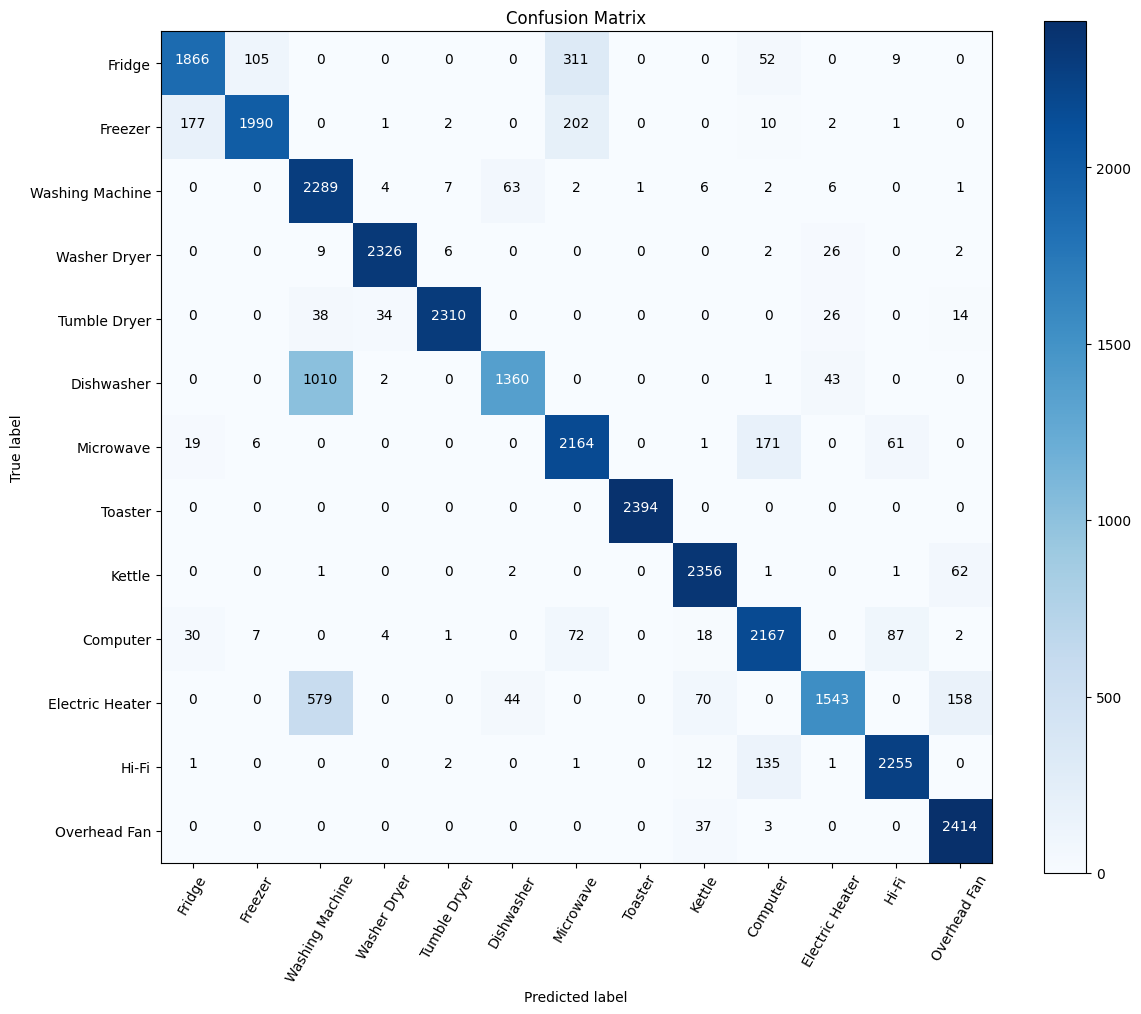

In [123]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)

In [124]:
from sklearn.metrics import classification_report 
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1),target_names=LABELS))

                 precision    recall  f1-score   support

       Computer       0.89      0.80      0.84      2343
     Dishwasher       0.94      0.83      0.89      2385
Electric Heater       0.58      0.96      0.73      2381
        Freezer       0.98      0.98      0.98      2371
         Fridge       0.99      0.95      0.97      2422
          Hi-Fi       0.93      0.56      0.70      2416
         Kettle       0.79      0.89      0.84      2422
      Microwave       1.00      1.00      1.00      2394
   Overhead Fan       0.94      0.97      0.96      2423
        Toaster       0.85      0.91      0.88      2388
   Tumble Dryer       0.94      0.64      0.76      2394
   Washer Dryer       0.93      0.94      0.94      2407
Washing Machine       0.91      0.98      0.95      2454

       accuracy                           0.88     31200
      macro avg       0.90      0.88      0.88     31200
   weighted avg       0.90      0.88      0.88     31200



In [125]:
# from keras import ops
from keras.models import save_model

save_model(model,'GLU_CNN_LSTM_model.keras')
print('Saved model to: GLU_CNN_LSTM_model.keras')


Saved model to: GLU_CNN_LSTM_model.keras


In [5]:
from keras.models import load_model

loaded_model = load_model('GLU_CNN_LSTM_model.keras', custom_objects ={'relu6_div6': Activation(relu6_div6), 'Conv1DGLUBlock': Activation(Conv1DGLUBlock), 'ResidualBlock': Activation(ResidualBlock)})


In [6]:
from keras.losses import Loss
from keras.saving import register_keras_serializable
import tensorflow as tf

@register_keras_serializable()
class FocalLoss(Loss):
    def __init__(self, gamma=2., alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return self.alpha * tf.pow(1. - pt, self.gamma) * bce

    def get_config(self):
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [19]:
from keras.metrics import BinaryAccuracy, AUC, Recall
from keras.layers import TimeDistributed, Dense, Bidirectional
from keras.optimizers import Adam

# Model Used for transfer learning for the aggregation task
def seq2seq_model(num_appliances):

    # loaded_model.summary()
    # for layer in loaded_model.layers[:8]:
    #     layer.trainable = False
    x = loaded_model.layers[-5].input

    seq2seq = ResidualBlock(filters=128, kernel_size=5)(x)
    seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

    # seq2seq = ResidualBlock(filters=256, kernel_size=5)(seq2seq)
    # seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

    seq2seq = ResidualBlock(filters=128, kernel_size=3)(seq2seq)
    seq2seq = MaxPooling1D(pool_size=1, strides=1)(seq2seq)

    seq2seq = Bidirectional(LSTM(64, return_sequences=True))(seq2seq)

    seq2seq = Dropout(0.2)(seq2seq)
    seq2seq = Bidirectional(LSTM(64, return_sequences=True))(seq2seq)
    seq2seq = TimeDistributed(Dense(128, activation='relu'))(seq2seq)
    seq2seq = Dropout(0.2)(seq2seq)


    seq2seq = Dense(num_appliances, activation='sigmoid')(seq2seq)
    # seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(x)

    import tensorflow as tf

    # Sort of a custom weighted binary crossentropy loss function
    # where we give more weight to positive samples (e.g., 5 times more)

    def weighted_binary_crossentropy(pos_weight=4.0):
        def loss_fn(y_true, y_pred):
            bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
            weights = 1.0 + pos_weight * y_true  # weight = 5 if y_true==1, else 1
            return tf.reduce_mean(bce * weights)
        return loss_fn

    loss = keras.losses.BinaryCrossentropy()
    weighted_loss = lambda y_true, y_pred: loss(y_true, y_pred) * (1 + 5*y_true)


    

    seq2seq_model = Model(inputs=loaded_model.input, outputs=seq2seq)
    seq2seq_model.compile(optimizer=Adam(learning_rate=0.0001), loss=FocalLoss(alpha=0.25), metrics=[BinaryAccuracy(name='binary_accuracy'),AUC(name='auc'), Recall(name='recall')])

    # # # Summary
    seq2seq_model.summary()
    return seq2seq_model

# import tensorflow as tf
# from keras.utils import get_custom_objects
# from keras.saving import register_keras_serializable
# @register_keras_serializable()
# def focal_loss(gamma=2., alpha=0.25):
#     def loss(y_true, y_pred):
#         bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#         pt = tf.exp(-bce)
#         return alpha * (1 - pt) ** gamma * bce
#     return loss
# get_custom_objects().update({'focal_loss': focal_loss})



In [36]:
import os
import pandas as pd

heavy_cycle_appliance = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher']
light_burst_appliance = ['Microwave', 'Kettle', 'Electric Heater']
NUM_SEQUENCES = 5000
# Function to load appliance data from a directory structure
def load_appliance_data(root_dir,temp_appliance_data):
    appliance_data = {}

    for appliance in temp_appliance_data:
        appliance_dir = os.path.join(root_dir, appliance)
        if not os.path.isdir(appliance_dir):
            continue

        all_series = []

        for file in os.listdir(appliance_dir):
            print(f"Processing file: {file}")
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(appliance_dir, file))

                power_col = appliance
                all_series.append(df[power_col].dropna().values)

        if all_series:
            appliance_data[appliance] = all_series

    print(f"Loaded data for {len(appliance_data)} appliances.")
    return appliance_data


In [46]:
import numpy as np
import random

def create_synthetic_dataset_from_csvs(
    appliance_data,
    sequence_length=512,
    num_sequences=1000,
    max_agg_power=8000,
    thresholds=None,
    max_attempts_per_seq=10
):
    if thresholds is None:
        thresholds = {
            'Fridge': 10,
            'Freezer': 10,
            'Washing Machine': 20,
            'Washer Dryer': 30,
            'Tumble Dryer': 100,
            'Dishwasher': 30,
            'Microwave': 10,
            'Toaster': 150,
            'Kettle': 50,
            'Computer': 20,
            'Electric Heater': 50,
            'Hi-Fi': 10,
            'Overhead Fan': 20
        }

    appliance_names = list(appliance_data.keys())
    min_appliances_on = 1
    max_appliances_total = len(appliance_names) - 1
    min_on_ratio = 0.6

    synthetic_X = []
    synthetic_Y = []

    random.seed(62)
    np.random.seed(62)

    # Track how many times each appliance has been ON
    appliance_on_counts = {name: 0 for name in appliance_names}
    target_per_appliance = num_sequences // len(appliance_names)

    sequence_idx = 0
    while sequence_idx < num_sequences:
        print(f"Generating sequence {sequence_idx + 1}/{num_sequences}")

        # Choose one appliance that is underrepresented
        underrepresented = [a for a in appliance_names if appliance_on_counts[a] < target_per_appliance]
        if not underrepresented:
            break  # All appliances have hit target

        target_appliance = random.choice(underrepresented)

        # Ensure target appliance is included
        other_appliances = [a for a in appliance_names if a != target_appliance]
        random_appliances = random.sample(
            other_appliances,
            k=random.randint(min_appliances_on - 1, max_appliances_total - 1)
        )
        selected_appliances = [target_appliance] + random_appliances

        for attempt in range(max_attempts_per_seq):
            agg_seq = np.zeros(sequence_length)
            appliance_power_matrix = np.zeros((sequence_length, len(appliance_names)))
            on_appliance_count = 0
            success = False

            for appliance in selected_appliances:
                idx = appliance_names.index(appliance)
                csv_list = appliance_data[appliance]
                if not csv_list:
                    continue

                threshold = thresholds.get(appliance, 50)
                found_on_segment = False

                for _ in range(5):
                    series = random.choice(csv_list)
                    if len(series) < sequence_length:
                        series = np.pad(series, (0, sequence_length - len(series)))
                    else:
                        start = random.randint(0, len(series) - sequence_length)
                        series = series[start:start + sequence_length]

                    if (series > threshold).sum() >= sequence_length * min_on_ratio:
                        found_on_segment = True
                        break

                if not found_on_segment:
                    continue

                temp_agg = agg_seq + series
                if np.max(temp_agg) <= max_agg_power:
                    agg_seq = temp_agg
                    appliance_power_matrix[:, idx] = series
                    on_appliance_count += 1

            # Check if target appliance is ON
            target_idx = appliance_names.index(target_appliance)
            if appliance_power_matrix[:, target_idx].sum() > 0:
                appliance_on_counts[target_appliance] += 1
                success = True

            if success and on_appliance_count >= min_appliances_on:
                # Downsample ON/OFF labels
                label_vector = []
                for i, appliance in enumerate(appliance_names):
                    threshold = thresholds.get(appliance, 50)
                    downsampled = appliance_power_matrix[:, i].reshape(-1, 4).mean(axis=1)
                    on_off = (downsampled > threshold).astype(int)
                    label_vector.append(on_off)

                label_matrix = np.stack(label_vector, axis=-1)
                synthetic_X.append(agg_seq.reshape(sequence_length, 1))
                synthetic_Y.append(label_matrix)
                sequence_idx += 1
                break  # Move to next sequence

    # Convert to arrays
    X = np.array(synthetic_X)
    y = np.array(synthetic_Y)

    # Shuffle the dataset
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]

    return X, y, appliance_names


In [38]:
heavy_cycle_appliance_data = load_appliance_data(DATA_DIR,heavy_cycle_appliance)
light_burst_appliance_data = load_appliance_data(DATA_DIR,light_burst_appliance)


Processing file: Fridge_House_1.csv_0.csv
Processing file: Fridge_House_1.csv_10.csv
Processing file: Fridge_House_1.csv_100.csv
Processing file: Fridge_House_1.csv_101.csv
Processing file: Fridge_House_1.csv_102.csv
Processing file: Fridge_House_1.csv_103.csv
Processing file: Fridge_House_1.csv_104.csv
Processing file: Fridge_House_1.csv_105.csv
Processing file: Fridge_House_1.csv_106.csv
Processing file: Fridge_House_1.csv_107.csv
Processing file: Fridge_House_1.csv_108.csv
Processing file: Fridge_House_1.csv_109.csv
Processing file: Fridge_House_1.csv_110.csv
Processing file: Fridge_House_1.csv_111.csv
Processing file: Fridge_House_1.csv_112.csv
Processing file: Fridge_House_1.csv_113.csv
Processing file: Fridge_House_1.csv_114.csv
Processing file: Fridge_House_1.csv_115.csv
Processing file: Fridge_House_1.csv_116.csv
Processing file: Fridge_House_1.csv_117.csv
Processing file: Fridge_House_1.csv_118.csv
Processing file: Fridge_House_1.csv_119.csv
Processing file: Fridge_House_1.csv

In [47]:
# Create synthetic dataset
X_h, Y_h, Labels_h = create_synthetic_dataset_from_csvs(heavy_cycle_appliance_data, sequence_length=300, num_sequences=40000)
X_l, Y_l, Labels_l = create_synthetic_dataset_from_csvs(light_burst_appliance_data, sequence_length=300, num_sequences=40000)

print("X shape (aggregated):", X_h.shape)  # (30000, 300, 1)
print("Y shape (labels):", Y_h.shape)      # (30000, 300, num_appliances)
print("Appliance order:", Labels_h)

print("Example aggregated input (first sequence):", X_h[0])  
print("Example aggregated input (first sequence):", Y_h[0])  

Generating sequence 1/40000
Generating sequence 2/40000
Generating sequence 3/40000
Generating sequence 4/40000
Generating sequence 5/40000
Generating sequence 6/40000
Generating sequence 7/40000
Generating sequence 8/40000
Generating sequence 9/40000
Generating sequence 10/40000
Generating sequence 11/40000
Generating sequence 12/40000
Generating sequence 13/40000
Generating sequence 14/40000
Generating sequence 15/40000
Generating sequence 16/40000
Generating sequence 17/40000
Generating sequence 18/40000
Generating sequence 19/40000
Generating sequence 20/40000
Generating sequence 21/40000
Generating sequence 22/40000
Generating sequence 23/40000
Generating sequence 24/40000
Generating sequence 25/40000
Generating sequence 26/40000
Generating sequence 27/40000
Generating sequence 28/40000
Generating sequence 29/40000
Generating sequence 30/40000
Generating sequence 31/40000
Generating sequence 32/40000
Generating sequence 33/40000
Generating sequence 34/40000
Generating sequence 35/

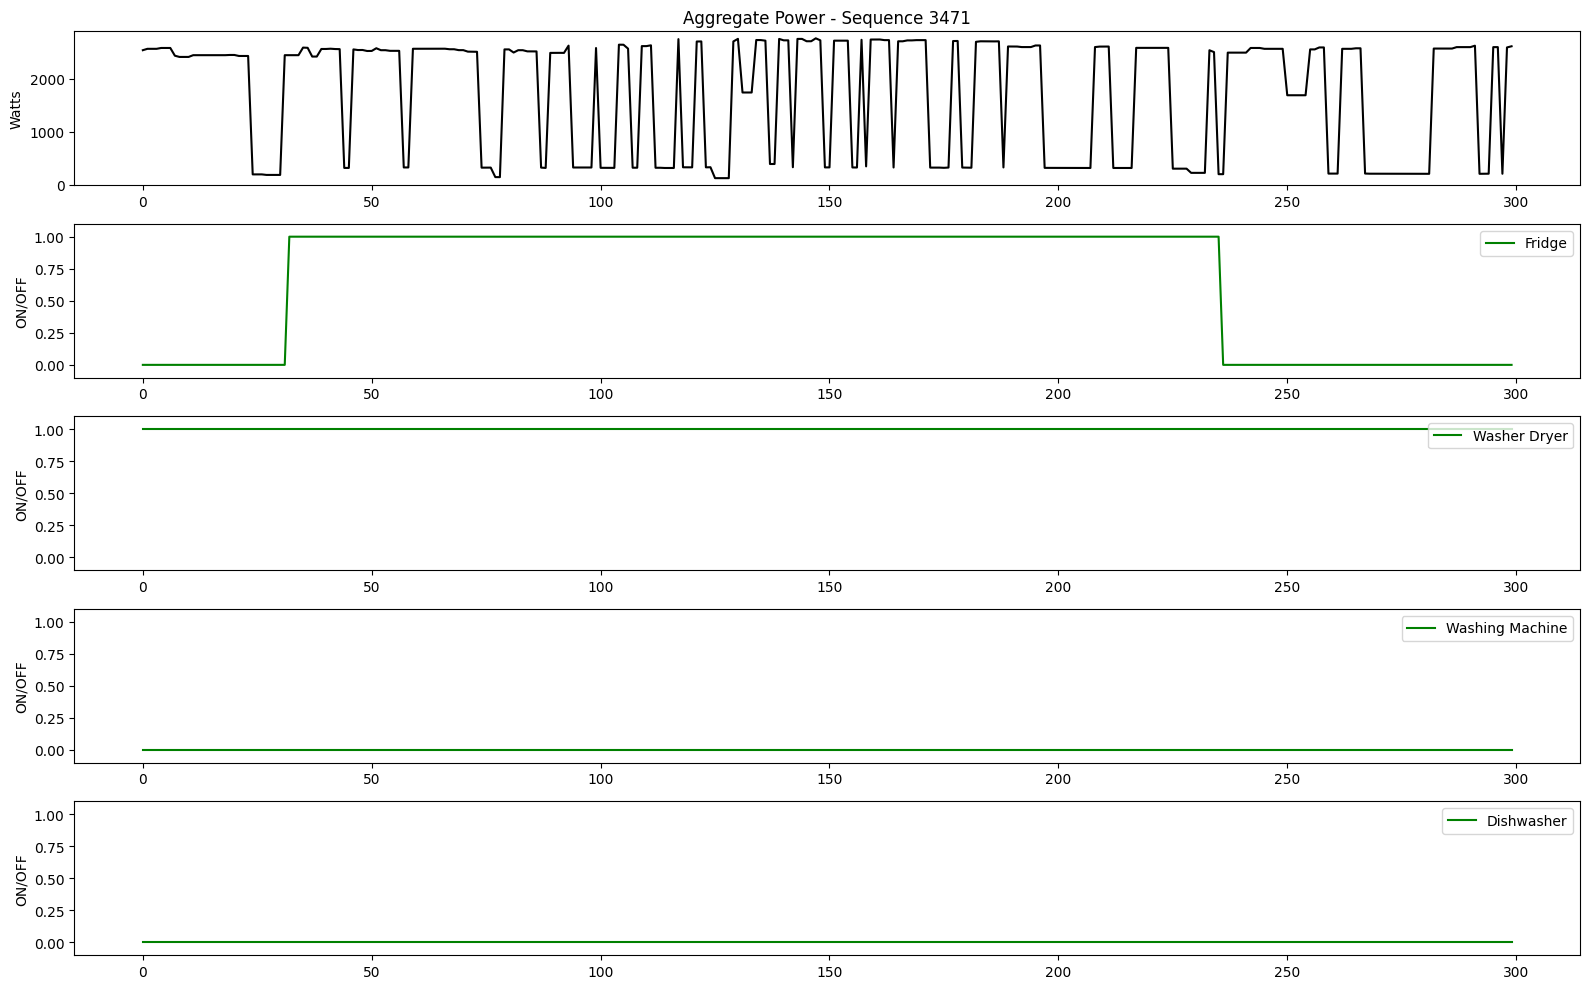

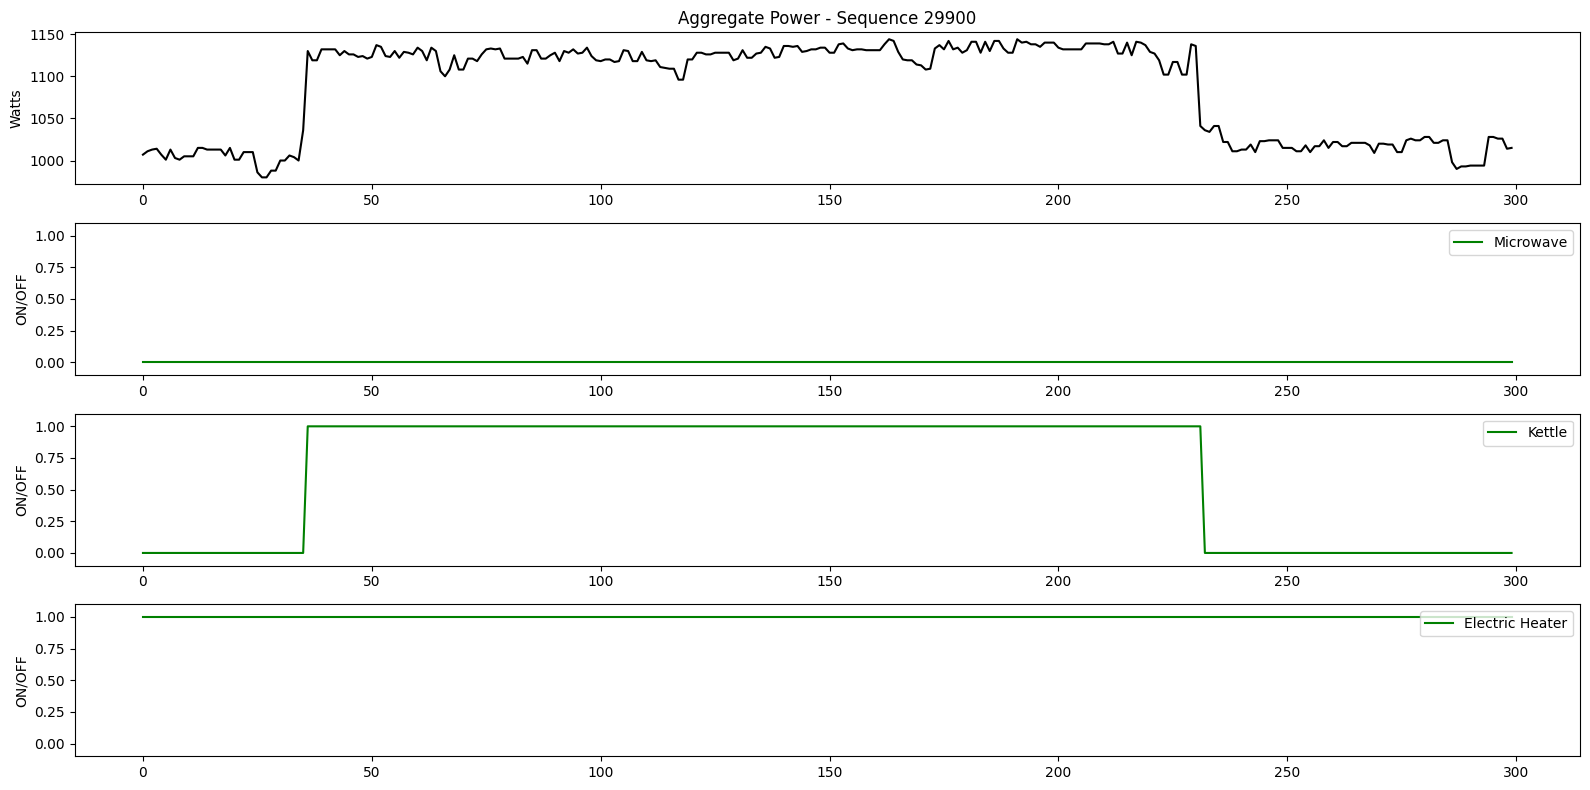

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_synthetic_examples(X, Y, appliance_names, num_examples=3):
    """
    Plot aggregate input signal and ON/OFF labels per appliance for a few sequences.

    Args:
        X (np.array): Shape (num_samples, sequence_length, 1)
        Y (np.array): Shape (num_samples, sequence_length_downsampled, num_appliances)
        appliance_names (List[str]): List of appliance names
        num_examples (int): Number of random examples to show
    """
    num_appliances = len(appliance_names)
    seq_len = X.shape[1]
    down_len = Y.shape[1]
    down_factor = seq_len // down_len

    indices = np.random.choice(len(X), size=num_examples, replace=False)

    for idx in indices:
        plt.figure(figsize=(16, 2 + 2 * num_appliances))
        
        # Plot aggregate power signal
        plt.subplot(num_appliances + 1, 1, 1)
        plt.plot(X[idx].squeeze(), color='black')
        plt.title(f'Aggregate Power - Sequence {idx}')
        plt.ylabel("Watts")

        # Plot each appliance ON/OFF label
        for i in range(num_appliances):
            plt.subplot(num_appliances + 1, 1, i + 2)
            plt.plot(np.repeat(Y[idx][:, i], down_factor), label=appliance_names[i], color='green')
            plt.ylabel("ON/OFF")
            plt.ylim(-0.1, 1.1)
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

appliance_names = [
    'Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher']

plot_synthetic_examples(X_h, Y_h, heavy_cycle_appliance, num_examples=1)
plot_synthetic_examples(X_l, Y_l, light_burst_appliance, num_examples=1)



In [13]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # What to track
    factor=0.5,           # Reduce LR by this factor
    patience=3,           # Wait this many epochs with no improvement
    min_lr=1e-6,          # Minimum LR to avoid going too low
    verbose=1             # Print updates
)

early_stopping = EarlyStopping(
    monitor='val_loss',   # What to track
    patience=5,           # Wait this many epochs with no improvement
    restore_best_weights=True,  # Restore best weights after stopping
    verbose=1             # Print updates
    )


In [50]:

# Show the class imbalance in the dataset
def imbalance_calc (y, dataset,temp_appliance_data):
    y_flat = y.reshape(-1, y.shape[-1])
    on_percentage = 100 * np.mean(y_flat, axis=0)
    off_percentage = 100 - on_percentage
    on_off_df = pd.DataFrame({
        f'Appliance in {dataset}': [f'{temp_appliance_data[i]}' for i in range(y.shape[-1])],
        'ON (%)': on_percentage,
        'OFF (%)': off_percentage
    })
    print(on_off_df)

imbalance_calc(Y_h,'Heavy Cycle Dataset', heavy_cycle_appliance)
imbalance_calc(Y_l,'Light Burst Dataset', light_burst_appliance)


  Appliance in Heavy Cycle Dataset     ON (%)    OFF (%)
0                           Fridge  43.011933  56.988067
1                     Washer Dryer  46.188867  53.811133
2                  Washing Machine  44.084767  55.915233
3                       Dishwasher  42.910867  57.089133
  Appliance in Light Burst Dataset     ON (%)    OFF (%)
0                        Microwave  34.730568  65.269432
1                           Kettle  40.188071  59.811929
2                  Electric Heater  40.007367  59.992633


In [163]:
print(f"Generated {len(X_h)} sequences with shape {X_h.shape} and labels shape {Y_h.shape}")
heavy_cycle_model = seq2seq_model(len(heavy_cycle_appliance))
history = heavy_cycle_model.fit(X_h, Y_h, epochs=20, batch_size=64, validation_split=0.1, callbacks=[reduce_lr])

Generated 40000 sequences with shape (40000, 300, 1) and labels shape (40000, 75, 4)


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_159 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_158 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 300, 64)   │          0 │ conv1d_159[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 300, 64)   │          0 │ conv1d_158[0][0], │
│ (Multiply)          │                   │            │ activation_73[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 300, 64)   │          0 │ conv1d_161[0][0], │
│                     │                   │            │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 150, 64)   │          0 │ add_44[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_163 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_162 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 150, 128)  │          0 │ conv1d_163[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_45         │ (None, 150, 128)  │          0 │ conv1d_162[0][0], │
│ (Multiply)          │                   │            │ activation_74[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_164 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_45[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 150, 128)  │          0 │ conv1d_165[0][0], │
│                     │                   │            │ conv1d_164[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 75, 128)   │          0 │ add_45[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_227 (Conv1D) │ (None, 75, 128)   │     82,048 │ max_pooling1d_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_226 (Conv1D) │ (None, 75, 128)   │     82,048 │ max_pooling1d_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 75, 128)   │          0 │ conv1d_227[0][0]  │
│ (Activation)        │                   │            │                 

 Total params: 589,636 (2.25 MB)

 Trainable params: 589,636 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 165s 262ms/step - auc: 0.5495 - binary_accuracy: 0.5568 - loss: 0.0429 - recall: 0.1965 - val_auc: 0.5773 - val_binary_accuracy: 0.5824 - val_loss: 0.0422 - val_recall: 0.1421 - learning_rate: 0.0050
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 133s 236ms/step - auc: 0.6214 - binary_accuracy: 0.5946 - loss: 0.0410 - recall: 0.3247 - val_auc: 0.6619 - val_binary_accuracy: 0.6183 - val_loss: 0.0404 - val_recall: 0.4075 - learning_rate: 0.0050
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 131s 233ms/step - auc: 0.6710 - binary_accuracy: 0.6224 - loss: 0.0397 - recall: 0.4669 - val_auc: 0.7492 - val_binary_accuracy: 0.6744 - val_loss: 0.0370 - val_recall: 0.5165 - learning_rate: 0.0050
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 132s 235ms/step - auc: 0.7054 - binary_accuracy: 0.6440 - loss: 0.0384 - recall: 0.5044 - val_auc: 0.7915 - val_binary_accuracy: 0.7105 - val_loss: 0.0341 - val_recall: 0.5876 - learning_rate: 0.0050
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 

In [51]:
print(f"Generated {len(X_l)} sequences with shape {X_l.shape} and labels shape {Y_l.shape}")
light_burst_model = seq2seq_model(len(light_burst_appliance))
history = light_burst_model.fit(X_l, Y_l, epochs=20, batch_size=64, validation_split=0.1, callbacks=[reduce_lr])

Generated 39999 sequences with shape (39999, 300, 1) and labels shape (39999, 75, 3)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_159 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_158 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 300, 64)   │          0 │ conv1d_159[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 300, 64)   │          0 │ conv1d_158[0][0], │
│ (Multiply)          │                   │            │ activation_73[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 300, 64)   │          0 │ conv1d_161[0][0], │
│                     │                   │            │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 150, 64)   │          0 │ add_44[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_163 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_162 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 150, 128)  │          0 │ conv1d_163[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_45         │ (None, 150, 128)  │          0 │ conv1d_162[0][0], │
│ (Multiply)          │                   │            │ activation_74[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_164 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_45[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 150, 128)  │          0 │ conv1d_165[0][0], │
│                     │                   │            │ conv1d_164[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 75, 128)   │          0 │ add_45[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 75, 128)   │     82,048 │ max_pooling1d_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 75, 128)   │     82,048 │ max_pooling1d_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 75, 128)   │          0 │ conv1d_37[0][0]   │
│ (Activation)        │                   │            │                 

 Total params: 589,507 (2.25 MB)

 Trainable params: 589,507 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 124s 200ms/step - auc: 0.6284 - binary_accuracy: 0.6285 - loss: 0.0403 - recall: 0.3355 - val_auc: 0.7441 - val_binary_accuracy: 0.7041 - val_loss: 0.0353 - val_recall: 0.3473 - learning_rate: 1.0000e-04
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 119s 212ms/step - auc: 0.7295 - binary_accuracy: 0.6869 - loss: 0.0363 - recall: 0.4326 - val_auc: 0.7835 - val_binary_accuracy: 0.7245 - val_loss: 0.0336 - val_recall: 0.5588 - learning_rate: 1.0000e-04
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 120s 212ms/step - auc: 0.7746 - binary_accuracy: 0.7172 - loss: 0.0340 - recall: 0.5015 - val_auc: 0.8155 - val_binary_accuracy: 0.7499 - val_loss: 0.0315 - val_recall: 0.5647 - learning_rate: 1.0000e-04
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 120s 213ms/step - auc: 0.7913 - binary_accuracy: 0.7235 - loss: 0.0329 - recall: 0.5181 - val_auc: 0.8132 - val_binary_accuracy: 0.7402 - val_loss: 0.0314 - val_recall: 0.5504 - learning_rate: 1.0000e-04
Epoch 5/20
563/563 ━━━━━

In [164]:
# Predict on train data
print(X_h.shape)
heavy_train_preds = heavy_cycle_model.predict(X_h.squeeze(axis=-1), verbose=1)

# Threshold predictions to 0/1 
heavy_preds_train_binary = (heavy_train_preds > 0.5).astype(int)


(40000, 300, 1)
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 77ms/step


In [165]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_appliances = heavy_preds_train_binary.shape[2]
per_appliance_acc_train = []
# Print accuracy, precision, recall, and F1 score for each appliance
for i in range(num_appliances):
    y_true = Y_h[:, :, i].flatten()
    y_pred = heavy_preds_train_binary[:, :, i].flatten()
    
    acc = accuracy_score(y_true, y_pred)
    per_appliance_acc_train.append(acc)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"{heavy_cycle_appliance[i]} - Train Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")


Fridge - Train Acc: 0.7325 | Prec: 0.7139 | Rec: 0.6316 | F1: 0.6702
Washer Dryer - Train Acc: 0.8837 | Prec: 0.8932 | Rec: 0.8484 | F1: 0.8702
Washing Machine - Train Acc: 0.8032 | Prec: 0.7762 | Rec: 0.7845 | F1: 0.7803
Dishwasher - Train Acc: 0.8115 | Prec: 0.7570 | Rec: 0.8184 | F1: 0.7865


In [52]:
# Predict on train data
print(X_l.shape)
light_train_preds = light_burst_model.predict(X_l.squeeze(axis=-1), verbose=1)

# Threshold predictions to 0/1 
light_preds_train_binary = (light_train_preds > 0.5).astype(int)

(39999, 300, 1)
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_appliances = light_preds_train_binary.shape[2]
per_appliance_acc_train = []
# Print accuracy, precision, recall, and F1 score for each appliance
for i in range(num_appliances):
    y_true = Y_l[:, :, i].flatten()
    y_pred = light_preds_train_binary[:, :, i].flatten()
    
    acc = accuracy_score(y_true, y_pred)
    per_appliance_acc_train.append(acc)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"{light_burst_appliance[i]} - Train Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

Microwave - Train Acc: 0.7481 | Prec: 0.8948 | Rec: 0.3112 | F1: 0.4618
Kettle - Train Acc: 0.7094 | Prec: 0.6347 | Rec: 0.6523 | F1: 0.6434
Electric Heater - Train Acc: 0.8393 | Prec: 0.9176 | Rec: 0.6572 | F1: 0.7659


In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gt_vs_prediction_lines(agg_signal, true_labels, pred_labels, appliance_names, sample_idx=0):
    """
    Plots aggregate signal and ON segments as dashed lines (--) for each appliance.
    Separate plots for ground truth and predictions.

    Parameters:
    - agg_signal: (sequence_length,) array
    - true_labels: (sequence_length // 4, num_appliances)
    - pred_labels: same shape
    - appliance_names: list of appliance names
    - sample_idx: index for labeling
    """
    num_appliances = true_labels.shape[1]
    sequence_length = len(agg_signal)
    downsample_factor = sequence_length // true_labels.shape[0]
    time_axis = np.arange(sequence_length)

    fig, axs = plt.subplots(3, 1, figsize=(16, 8), sharex=True,
                            gridspec_kw={'height_ratios': [1.5, 1, 1]})

    # Plot aggregate power
    axs[0].plot(time_axis, agg_signal, color='black', linewidth=1.5)
    axs[0].set_title("Aggregate Power")
    axs[0].set_ylabel("Power (W)")
    axs[0].grid(True)

    # Plot Ground Truth
    for i in range(num_appliances):
        y_pos = i  # vertical position for the appliance line
        for t in range(true_labels.shape[0]):
            if true_labels[t, i] == 1:
                start = t * downsample_factor
                end = (t + 1) * downsample_factor
                axs[1].hlines(y=y_pos, xmin=start, xmax=end, colors='green', linestyles='--', linewidth=2)

    axs[1].set_yticks(range(num_appliances))
    axs[1].set_yticklabels(appliance_names)
    axs[1].set_title("Ground Truth Appliance Activations")
    axs[1].grid(True)

    # Plot Predictions
    for i in range(num_appliances):
        y_pos = i
        for t in range(pred_labels.shape[0]):
            if pred_labels[t, i] == 1:
                start = t * downsample_factor
                end = (t + 1) * downsample_factor
                axs[2].hlines(y=y_pos, xmin=start, xmax=end, colors='blue', linestyles='--', linewidth=2)

    axs[2].set_yticks(range(num_appliances))
    axs[2].set_yticklabels(appliance_names)
    axs[2].set_title("Predicted Appliance Activations")
    axs[2].set_xlabel("Time Steps")
    axs[2].grid(True)

    plt.tight_layout()
    plt.suptitle(f"Sample {sample_idx}: Ground Truth vs Prediction", fontsize=16, y=1.02)
    plt.show()


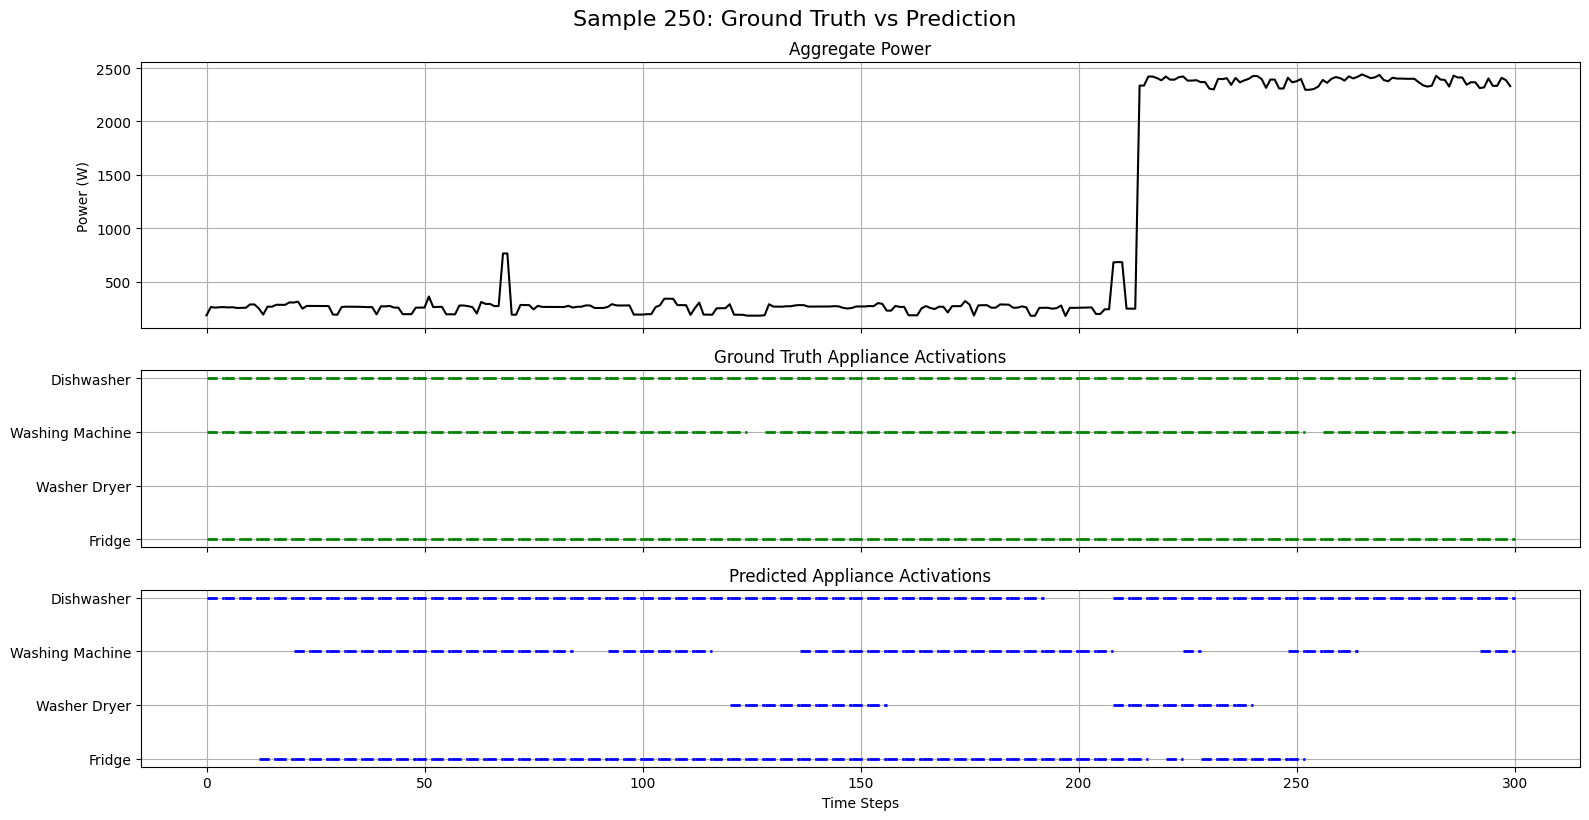

In [188]:
sample_idx = 250

agg_signal = X_h[sample_idx].squeeze()
true_labels = Y_h[sample_idx]
pred_labels = heavy_preds_train_binary[sample_idx]  # shape: (128, num_appliances)

plot_gt_vs_prediction_lines(agg_signal, true_labels, pred_labels, heavy_cycle_appliance, sample_idx)


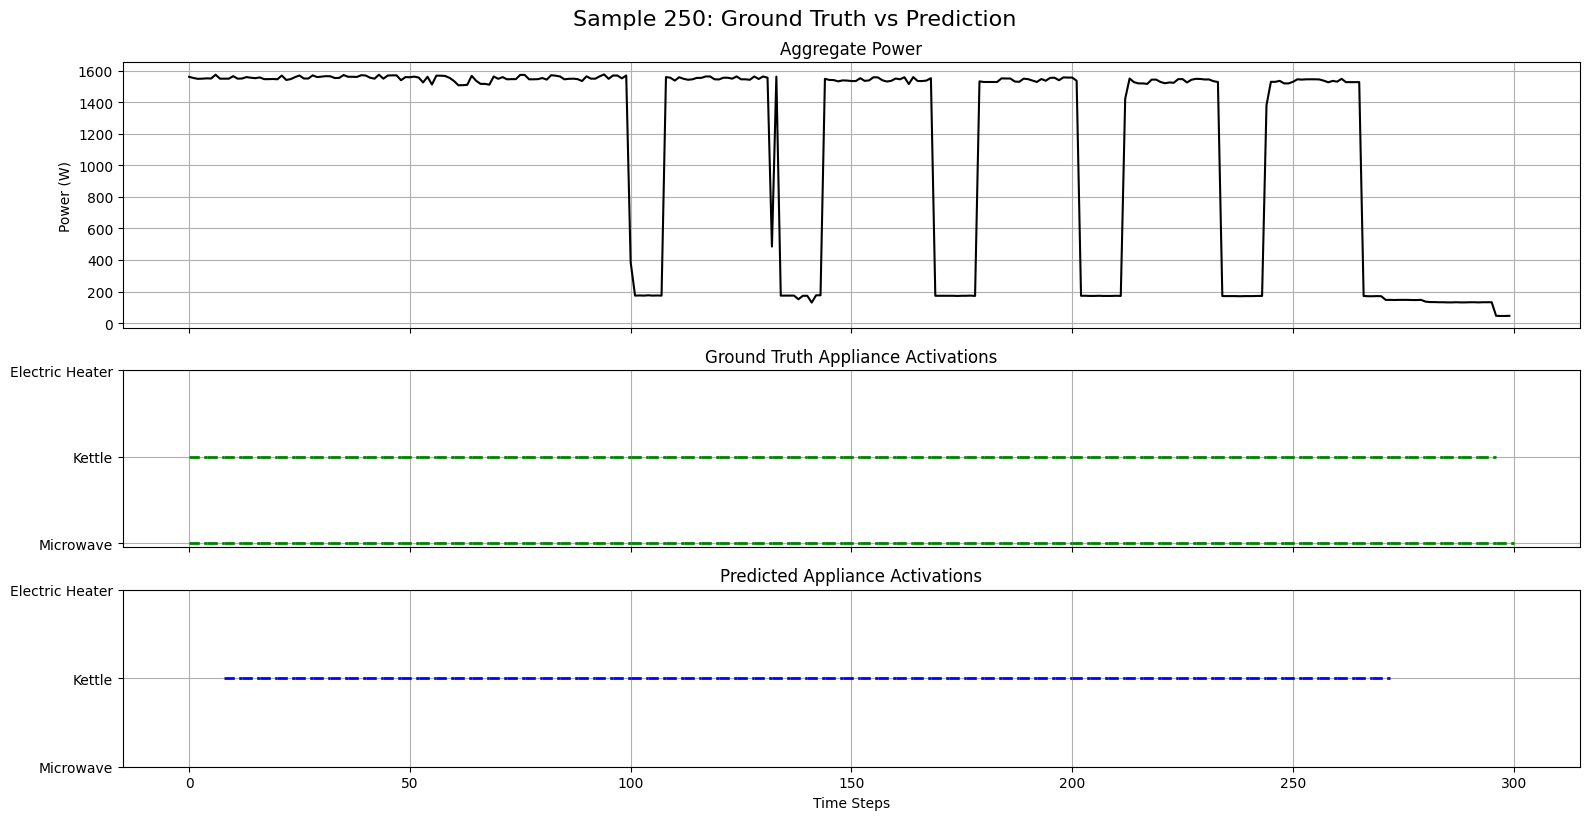

In [25]:
sample_idx = 250

agg_signal = X_l[sample_idx].squeeze()
true_labels = Y_l[sample_idx]
pred_labels = light_preds_train_binary[sample_idx]  # shape: (128, num_appliances)

plot_gt_vs_prediction_lines(agg_signal, true_labels, pred_labels, light_burst_appliance, sample_idx)

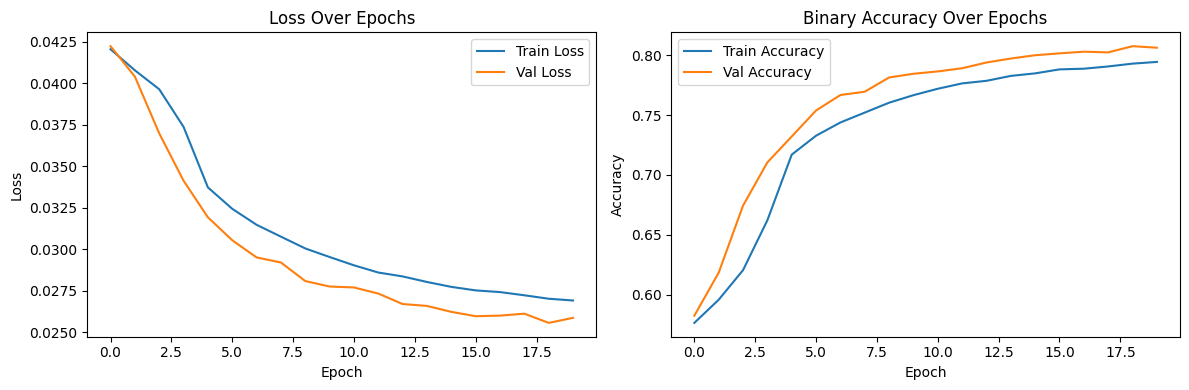

In [168]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PARAMETERS
WINDOW_SIZE = 300
STRIDE = 150
TARGET_COLUMNS = ['Fridge', 'Washer Dryer', 'Washing Machine', 'Dishwasher',
                  'Television', 'Hi-Fi','Microwave', 'Kettle', 'Electric Heater']
AGG_COLUMN = 'Aggregate'
UNIX_COLUMN = 'Unix'
NUM_SAMPLES = 10000

# Load CSV
df = pd.read_csv(f'{DATA_DIR}/House_9.csv')

# Drop unnecessary columns (keep only aggregate + target appliances)
df = df[[AGG_COLUMN, *TARGET_COLUMNS, UNIX_COLUMN]]


# Function to create windowed sequences
def create_sequences(data, target_appliances= TARGET_COLUMNS, appliances_to_remove = [],window_size=300, stride=150):
    count = 0
    X = []
    y = []

    # Get column indices
    agg_idx = data.columns.get_loc(AGG_COLUMN)

    remove_idxs = [data.columns.get_loc(col) for col in appliances_to_remove]
    
    new_data = data.drop(columns=appliances_to_remove, errors='ignore')
    target_appliances = [col for col in target_appliances if col not in appliances_to_remove]
    target_idxs = [new_data.columns.get_loc(col) for col in target_appliances]
    for i in range(0, len(new_data) - window_size, stride):
        if count >= NUM_SAMPLES:
            break

        window = new_data.iloc[i:i + window_size].fillna(0).values.astype(np.float32)
        for_data_removal = data.iloc[i:i + window_size].fillna(0).values.astype(np.float32)


        # Aggregate signal (1D input)
        agg_window = np.copy(window[:, agg_idx])
        print(window.shape)
        print(agg_window.shape)
        for idx in remove_idxs:

            agg_window -= for_data_removal[:, idx]

        # Aggregate signal (1D input)

        X.append(agg_window)  # shape: (300, 1)

        # Extract target appliance usage
        target_data = window[:, target_idxs]  # shape: (300, num_appliances)

        # Downsample to 75 by averaging every 4 rows
        chunks = np.split(target_data[:300], 75)  # 300/4 = 75
        
        combined_chunks = np.array([
        chunk.min(axis=0)  # min across 4 samples → shape: (9,)
        for chunk in chunks
        ])  # shape: (75, 9)
        
        y.append(combined_chunks)

        count += 1
        print(count)

    y = np.array(y)

# Apply threshold after conversion to NumPy array
    y = (y > 10).astype(int)

    return np.array(X), np.array(y)

X_test_h, y_test_h = create_sequences(df,appliances_to_remove=['Kettle','Microwave','Electric Heater','Television','Hi-Fi'], window_size=WINDOW_SIZE, stride=STRIDE)
X_test_l, y_test_l = create_sequences(df,appliances_to_remove=['Fridge', 'Washing Machine','Washer Dryer','Dishwasher','Television','Hi-Fi'], window_size=WINDOW_SIZE, stride=STRIDE)


(300, 6)
(300,)
1
(300, 6)
(300,)
2
(300, 6)
(300,)
3
(300, 6)
(300,)
4
(300, 6)
(300,)
5
(300, 6)
(300,)
6
(300, 6)
(300,)
7
(300, 6)
(300,)
8
(300, 6)
(300,)
9
(300, 6)
(300,)
10
(300, 6)
(300,)
11
(300, 6)
(300,)
12
(300, 6)
(300,)
13
(300, 6)
(300,)
14
(300, 6)
(300,)
15
(300, 6)
(300,)
16
(300, 6)
(300,)
17
(300, 6)
(300,)
18
(300, 6)
(300,)
19
(300, 6)
(300,)
20
(300, 6)
(300,)
21
(300, 6)
(300,)
22
(300, 6)
(300,)
23
(300, 6)
(300,)
24
(300, 6)
(300,)
25
(300, 6)
(300,)
26
(300, 6)
(300,)
27
(300, 6)
(300,)
28
(300, 6)
(300,)
29
(300, 6)
(300,)
30
(300, 6)
(300,)
31
(300, 6)
(300,)
32
(300, 6)
(300,)
33
(300, 6)
(300,)
34
(300, 6)
(300,)
35
(300, 6)
(300,)
36
(300, 6)
(300,)
37
(300, 6)
(300,)
38
(300, 6)
(300,)
39
(300, 6)
(300,)
40
(300, 6)
(300,)
41
(300, 6)
(300,)
42
(300, 6)
(300,)
43
(300, 6)
(300,)
44
(300, 6)
(300,)
45
(300, 6)
(300,)
46
(300, 6)
(300,)
47
(300, 6)
(300,)
48
(300, 6)
(300,)
49
(300, 6)
(300,)
50
(300, 6)
(300,)
51
(300, 6)
(300,)
52
(300, 6)
(300,)
53
(3

In [27]:
# Predict on test data
heavy_preds = heavy_cycle_model.predict(X_test_h)

# Threshold predictions to 0/1 (optional: use different threshold)
heavy_preds_binary = (heavy_preds > 0.5).astype(int)


NameError: name 'heavy_cycle_model' is not defined

In [54]:
light_preds = light_burst_model.predict(X_test_l)

# Threshold predictions to 0/1 (optional: use different threshold)
light_preds_binary = (light_preds > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


In [57]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# y_test and preds_binary shape: (num_samples, num_appliances)

# Overall accuracy (flatten all)
def flatten_and_compare(Y, Y_pred, appliance_names):
    num_appliances = Y_pred.shape[2]
    per_appliance_acc_train = []
    # Print accuracy, precision, recall, and F1 score for each appliance
    for i in range(num_appliances):
        y_true = Y[:, :, i].flatten()
        y_pred = Y_pred[:, :, i].flatten()
        
        acc = accuracy_score(y_true, y_pred)
        per_appliance_acc_train.append(acc)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(f"{appliance_names[i]} - Test Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

# print('Heavy Appliance Test Results:')
# flatten_and_compare(y_test_h, heavy_preds_binary, heavy_cycle_appliance)
print('Light Appliance Test Results:')
flatten_and_compare(y_test_l, light_preds_binary, light_burst_appliance)

Light Appliance Test Results:
Microwave - Test Acc: 0.8683 | Prec: 0.0260 | Rec: 0.3852 | F1: 0.0487
Kettle - Test Acc: 0.5817 | Prec: 0.0004 | Rec: 0.1623 | F1: 0.0009
Electric Heater - Test Acc: 0.8766 | Prec: 0.0429 | Rec: 0.2382 | F1: 0.0727


In [171]:
# from keras import ops
from keras.models import save_model

save_model(heavy_cycle_model,'heavy_cycle_seq2seq_model.keras')
print('Saved model to: heavy_cycle_seq2seq_model.keras')


Saved model to: heavy_cycle_seq2seq_model.keras


In [189]:
# from keras import ops
from keras.models import save_model

save_model(light_burst_model,'light_burst_seq2seq_model.keras')
print('Saved model to: light_burst_seq2seq_model.keras')

Saved model to: light_burst_seq2seq_model.keras


In [58]:
from keras.models import load_model

classification_heavy_cycle_loaded_model = load_model('heavy_cycle_seq2seq_model.keras', custom_objects={
    'relu6_div6': (relu6_div6),
    'Conv1DGLUBlock': (Conv1DGLUBlock),
    'ResidualBlock': (ResidualBlock),
    })
classification_light_burst_loaded_model = load_model('light_burst_seq2seq_model.keras', custom_objects={
    'relu6_div6': (relu6_div6),
    'Conv1DGLUBlock': (Conv1DGLUBlock),
    'ResidualBlock': (ResidualBlock),
    })


In [59]:
loaded_heavy_preds = classification_heavy_cycle_loaded_model.predict(X_test_h)

# Threshold predictions to 0/1 (optional: use different threshold)
loaded_heavy_preds_binary = (loaded_heavy_preds > 0.5).astype(int)

print('Heavy Appliance Test Results:')
flatten_and_compare(y_test_h, loaded_heavy_preds_binary, heavy_cycle_appliance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
Heavy Appliance Test Results:
Fridge - Test Acc: 0.5774 | Prec: 0.5709 | Rec: 0.8440 | F1: 0.6811
Washer Dryer - Test Acc: 0.7441 | Prec: 0.1365 | Rec: 0.8788 | F1: 0.2363
Washing Machine - Test Acc: 0.8904 | Prec: 0.0978 | Rec: 0.6087 | F1: 0.1686
Dishwasher - Test Acc: 0.8573 | Prec: 0.2413 | Rec: 0.6920 | F1: 0.3578


In [60]:
loaded_light_preds = classification_light_burst_loaded_model.predict(X_test_h)

# Threshold predictions to 0/1 (optional: use different threshold)
loaded_light_preds_binary = (loaded_light_preds > 0.5).astype(int)

print('Heavy Appliance Test Results:')
flatten_and_compare(y_test_l, loaded_light_preds_binary, light_burst_appliance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step
Heavy Appliance Test Results:
Microwave - Test Acc: 0.6841 | Prec: 0.0202 | Rec: 0.7406 | F1: 0.0394
Kettle - Test Acc: 0.5196 | Prec: 0.0006 | Rec: 0.2788 | F1: 0.0013
Electric Heater - Test Acc: 0.9048 | Prec: 0.1319 | Rec: 0.6605 | F1: 0.2199


In [63]:
print(X_test_h.shape)
print(y_test_h.shape)

(10000, 300)
(10000, 75, 4)


In [68]:
from keras.losses import MeanAbsoluteError, MeanSquaredError

def build_seq2seq_regression(loaded_model, num_classes=4):

# loaded_model.summary()
    # for layer in loaded_model.layers[:8]:
    #     layer.trainable = False
    x = loaded_model.layers[-3].input

    # print(f"Shape of second-last layer output: {x.shape}")
    # seq2seq = LSTM(64, return_sequences=True, name="lstm_seq")(x)
    # seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(seq2seq)
    # Compile

    seq2seq = Dense(num_classes, activation='linear')(x)
    # seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(x)


    seq2seq_model = Model(inputs=loaded_model.input, outputs=seq2seq)
    seq2seq_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=[MeanAbsoluteError(), MeanSquaredError()])

    # # # Summary
    seq2seq_model.summary()
    return seq2seq_model

In [64]:
import numpy as np
import random

def create_synthetic_dataset_for_regression(
    appliance_data,
    sequence_length=512,
    num_sequences=1000,
    max_agg_power=8000,
    thresholds=None,
    max_attempts_per_seq=10
):
    if thresholds is None:
        thresholds = {
            'Fridge': 10,
            'Freezer': 10,
            'Washing Machine': 20,
            'Washer Dryer': 30,
            'Tumble Dryer': 100,
            'Dishwasher': 30,
            'Microwave': 10,
            'Toaster': 150,
            'Kettle': 50,
            'Computer': 20,
            'Electric Heater': 50,
            'Hi-Fi': 10,
            'Overhead Fan': 20
        }

    appliance_names = list(appliance_data.keys())
    min_appliances_on = 1
    max_appliances_total = len(appliance_names) - 1
    min_on_ratio = 0.6

    synthetic_X = []
    synthetic_Y = []

    random.seed(62)
    np.random.seed(62)

    # Track how many times each appliance has been ON
    appliance_on_counts = {name: 0 for name in appliance_names}
    target_per_appliance = num_sequences // len(appliance_names)

    sequence_idx = 0
    while sequence_idx < num_sequences:
        print(f"Generating sequence {sequence_idx + 1}/{num_sequences}")

        # Choose one appliance that is underrepresented
        underrepresented = [a for a in appliance_names if appliance_on_counts[a] < target_per_appliance]
        if not underrepresented:
            break  # All appliances have hit target

        target_appliance = random.choice(underrepresented)

        # Ensure target appliance is included
        other_appliances = [a for a in appliance_names if a != target_appliance]
        random_appliances = random.sample(
            other_appliances,
            k=random.randint(min_appliances_on - 1, max_appliances_total - 1)
        )
        selected_appliances = [target_appliance] + random_appliances

        for attempt in range(max_attempts_per_seq):
            agg_seq = np.zeros(sequence_length)
            appliance_power_matrix = np.zeros((sequence_length, len(appliance_names)))
            on_appliance_count = 0
            success = False

            for appliance in selected_appliances:
                idx = appliance_names.index(appliance)
                csv_list = appliance_data[appliance]
                if not csv_list:
                    continue

                threshold = thresholds.get(appliance, 50)
                found_on_segment = False

                for _ in range(5):
                    series = random.choice(csv_list)
                    if len(series) < sequence_length:
                        series = np.pad(series, (0, sequence_length - len(series)))
                    else:
                        start = random.randint(0, len(series) - sequence_length)
                        series = series[start:start + sequence_length]

                    if (series > threshold).sum() >= sequence_length * min_on_ratio:
                        found_on_segment = True
                        break

                if not found_on_segment:
                    continue

                temp_agg = agg_seq + series
                if np.max(temp_agg) <= max_agg_power:
                    agg_seq = temp_agg
                    appliance_power_matrix[:, idx] = series
                    on_appliance_count += 1

            # Check if target appliance is ON
            target_idx = appliance_names.index(target_appliance)
            if appliance_power_matrix[:, target_idx].sum() > 0:
                appliance_on_counts[target_appliance] += 1
                success = True

            if success and on_appliance_count >= min_appliances_on:
                # Downsample ON/OFF labels
                label_vector = []
                for i, appliance in enumerate(appliance_names):
                    threshold = thresholds.get(appliance, 50)
                    downsampled = appliance_power_matrix[:, i].reshape(-1, 4).min(axis=1)
                    # on_off = (downsampled > threshold).astype(int)
                    label_vector.append(downsampled)

                label_matrix = np.stack(label_vector, axis=-1)
                synthetic_X.append(agg_seq.reshape(sequence_length, 1))
                synthetic_Y.append(label_matrix)
                sequence_idx += 1
                break  # Move to next sequence

    # Convert to arrays
    X = np.array(synthetic_X)
    y = np.array(synthetic_Y)

    # Shuffle the dataset
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]

    return X, y, appliance_names


In [65]:
full_appliances = heavy_cycle_appliance + light_burst_appliance
full_appliance_data = load_appliance_data(DATA_DIR,full_appliances)
# Create synthetic dataset
X, Y, Labels = create_synthetic_dataset_from_csvs(full_appliance_data, sequence_length=300, num_sequences=40000)
# X_l, Y_l, Labels_l = create_synthetic_dataset_from_csvs(light_burst_appliance_data, sequence_length=300, num_sequences=40000)

print("X shape (aggregated):", X.shape)  # (30000, 300, 1)
print("Y shape (labels):", Y.shape)      # (30000, 300, num_appliances)
print("Appliance order:", Labels)

# print("Example aggregated input (first sequence):", X_h[0])  
# print("Example aggregated input (first sequence):", Y_h[0])  

Processing file: Fridge_House_1.csv_0.csv
Processing file: Fridge_House_1.csv_10.csv
Processing file: Fridge_House_1.csv_100.csv
Processing file: Fridge_House_1.csv_101.csv
Processing file: Fridge_House_1.csv_102.csv
Processing file: Fridge_House_1.csv_103.csv
Processing file: Fridge_House_1.csv_104.csv
Processing file: Fridge_House_1.csv_105.csv
Processing file: Fridge_House_1.csv_106.csv
Processing file: Fridge_House_1.csv_107.csv
Processing file: Fridge_House_1.csv_108.csv
Processing file: Fridge_House_1.csv_109.csv
Processing file: Fridge_House_1.csv_110.csv
Processing file: Fridge_House_1.csv_111.csv
Processing file: Fridge_House_1.csv_112.csv
Processing file: Fridge_House_1.csv_113.csv
Processing file: Fridge_House_1.csv_114.csv
Processing file: Fridge_House_1.csv_115.csv
Processing file: Fridge_House_1.csv_116.csv
Processing file: Fridge_House_1.csv_117.csv
Processing file: Fridge_House_1.csv_118.csv
Processing file: Fridge_House_1.csv_119.csv
Processing file: Fridge_House_1.csv

In [66]:

# Show the class imbalance in the dataset
def imbalance_calc (y, dataset,temp_appliance_data):
    y_flat = y.reshape(-1, y.shape[-1])
    on_percentage = 100 * np.mean(y_flat, axis=0)
    off_percentage = 100 - on_percentage
    on_off_df = pd.DataFrame({
        f'Appliance in {dataset}': [f'{temp_appliance_data[i]}' for i in range(y.shape[-1])],
        'ON (%)': on_percentage,
        'OFF (%)': off_percentage
    })
    print(on_off_df)

imbalance_calc(Y,'Full Dataset', full_appliances)



  Appliance in Full Dataset     ON (%)    OFF (%)
0                    Fridge  43.167125  56.832875
1              Washer Dryer  45.193826  54.806174
2           Washing Machine  44.244912  55.755088
3                Dishwasher  42.330017  57.669983
4                 Microwave  21.097155  78.902845
5                    Kettle  31.862593  68.137407
6           Electric Heater  32.852343  67.147657


In [71]:
print(f"Generated {len(X)} sequences with shape {X.shape} and labels shape {Y.shape}")
regression_model = build_seq2seq_regression(classification_heavy_cycle_loaded_model, len(full_appliances))
history1 = regression_model.fit(X, Y, epochs=10, batch_size=64, validation_split=0.1)

Generated 39998 sequences with shape (39998, 300, 1) and labels shape (39998, 75, 7)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_159 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_158 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 300, 64)   │          0 │ conv1d_159[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 300, 64)   │          0 │ conv1d_158[0][0], │
│ (Multiply)          │                   │            │ activation_73[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 300, 64)   │          0 │ conv1d_161[0][0], │
│                     │                   │            │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 150, 64)   │          0 │ add_44[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_163 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_162 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 150, 128)  │          0 │ conv1d_163[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_45         │ (None, 150, 128)  │          0 │ conv1d_162[0][0], │
│ (Multiply)          │                   │            │ activation_74[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_164 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_45[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 150, 128)  │          0 │ conv1d_165[0][0], │
│                     │                   │            │ conv1d_164[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 75, 128)   │          0 │ add_45[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_227 (Conv1D) │ (None, 75, 128)   │     82,048 │ max_pooling1d_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_226 (Conv1D) │ (None, 75, 128)   │     82,048 │ max_pooling1d_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 75, 128)   │          0 │ conv1d_227[0][0]  │
│ (Activation)        │                   │            │                 

 Total params: 573,511 (2.19 MB)

 Trainable params: 573,511 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 112s 173ms/step - loss: 0.1914 - mean_absolute_error: 0.3710 - mean_squared_error: 0.1914 - val_loss: 0.1664 - val_mean_absolute_error: 0.3459 - val_mean_squared_error: 0.1664
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 92s 164ms/step - loss: 0.1682 - mean_absolute_error: 0.3421 - mean_squared_error: 0.1682 - val_loss: 0.1670 - val_mean_absolute_error: 0.3390 - val_mean_squared_error: 0.1670
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 92s 163ms/step - loss: 0.1675 - mean_absolute_error: 0.3406 - mean_squared_error: 0.1675 - val_loss: 0.1657 - val_mean_absolute_error: 0.3362 - val_mean_squared_error: 0.1656
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 92s 164ms/step - loss: 0.1666 - mean_absolute_error: 0.3391 - mean_squared_error: 0.1666 - val_loss: 0.1633 - val_mean_absolute_error: 0.3335 - val_mean_squared_error: 0.1633
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 91s 161ms/step - loss: 0.1657 - mean_absolute_error: 0.3376 - mean_squared_error: 0.1657 - val_loss

In [72]:
X_test_full, y_test_full = create_sequences(df,appliances_to_remove=['Television','Hi-Fi'], window_size=WINDOW_SIZE, stride=STRIDE)


(300, 9)
(300,)
1
(300, 9)
(300,)
2
(300, 9)
(300,)
3
(300, 9)
(300,)
4
(300, 9)
(300,)
5
(300, 9)
(300,)
6
(300, 9)
(300,)
7
(300, 9)
(300,)
8
(300, 9)
(300,)
9
(300, 9)
(300,)
10
(300, 9)
(300,)
11
(300, 9)
(300,)
12
(300, 9)
(300,)
13
(300, 9)
(300,)
14
(300, 9)
(300,)
15
(300, 9)
(300,)
16
(300, 9)
(300,)
17
(300, 9)
(300,)
18
(300, 9)
(300,)
19
(300, 9)
(300,)
20
(300, 9)
(300,)
21
(300, 9)
(300,)
22
(300, 9)
(300,)
23
(300, 9)
(300,)
24
(300, 9)
(300,)
25
(300, 9)
(300,)
26
(300, 9)
(300,)
27
(300, 9)
(300,)
28
(300, 9)
(300,)
29
(300, 9)
(300,)
30
(300, 9)
(300,)
31
(300, 9)
(300,)
32
(300, 9)
(300,)
33
(300, 9)
(300,)
34
(300, 9)
(300,)
35
(300, 9)
(300,)
36
(300, 9)
(300,)
37
(300, 9)
(300,)
38
(300, 9)
(300,)
39
(300, 9)
(300,)
40
(300, 9)
(300,)
41
(300, 9)
(300,)
42
(300, 9)
(300,)
43
(300, 9)
(300,)
44
(300, 9)
(300,)
45
(300, 9)
(300,)
46
(300, 9)
(300,)
47
(300, 9)
(300,)
48
(300, 9)
(300,)
49
(300, 9)
(300,)
50
(300, 9)
(300,)
51
(300, 9)
(300,)
52
(300, 9)
(300,)
53
(3

In [74]:
preds_regression = regression_model.predict(X_test_full)

# Threshold predictions to 0/1 (optional: use different threshold)
preds_regression_binary = (preds_regression > 0.5).astype(int)

print('Heavy Appliance Test Results:')
flatten_and_compare(y_test_full, preds_regression_binary, full_appliances)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step
Heavy Appliance Test Results:
Fridge - Test Acc: 0.4600 | Prec: 0.4876 | Rec: 0.1937 | F1: 0.2772
Washer Dryer - Test Acc: 0.8923 | Prec: 0.2717 | Rec: 0.8275 | F1: 0.4091
Washing Machine - Test Acc: 0.8888 | Prec: 0.1045 | Rec: 0.6733 | F1: 0.1810
Dishwasher - Test Acc: 0.8957 | Prec: 0.2921 | Rec: 0.5733 | F1: 0.3871
Microwave - Test Acc: 0.9937 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
Kettle - Test Acc: 0.9709 | Prec: 0.0724 | Rec: 0.1966 | F1: 0.1058
Electric Heater - Test Acc: 0.9330 | Prec: 0.1762 | Rec: 0.6257 | F1: 0.2749


In [ ]:

heavy_probs = classification_heavy_cycle_loaded_model.predict(X_test_full)
light_probs = classification_light_burst_loaded_model.predict(X_test_full)
full_preds = np.zeros_like(y_test_full)


for i in range (len(y_test_full)):
    for j in range (len(y_test_full[i])):
        full_preds[i][j] = heavy_probs[i][j] + light_probs[i][j]
        # if heavy_probs[i][j] > 0.7 and light_probs[i][j] > 0.7:
        #     full_preds[i][j] = 1
        # elif max(heavy_probs[i][j], light_probs[i][j]) > 0.5:
        #     full_preds[i][j] = 1